In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 16*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh

from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2
from lidar_nerf_utils import *

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-08-05 10:25:01.480873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 10:25:01.589734: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 10:25:01.994185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-08-05 10:25:01.994263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-05 10:25:02.775285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 10:25:02.775668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 10:25:02.775970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 10:25:03.081743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 10:25:03.081951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses) #TRY COMMENTING OUT...

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)
idx = np.argwhere(rot_vel_euls > (np.pi))
rot_vel_euls[idx] = 0
idx = np.argwhere(rot_vel_euls < (-np.pi))
rot_vel_euls[idx] = 0

pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# #LOAD [-15,17.5]x1000, @0.005
# np.save("/home/derm/Desktop/posesEval.npy", poses)
# np.save("/home/derm/Desktop/imagesEval.npy", images)
poses = np.load("/home/derm/Desktop/poses.npy") # <--- used these for best NeRF training
images = np.load("/home/derm/Desktop/images.npy")
# poses = np.load("/home/derm/Desktop/posesEval.npy") # <--- every 5th frame, [7700:8800] for benchmarking
# images = np.load("/home/derm/Desktop/imagesEval.npy")
#LOAD [-17.5,15]x1000, @0.005
# np.save("/home/derm/Desktop/posesM17P15.npy", poses)
# np.save("/home/derm/Desktop/imagesM17P15.npy", images)
# poses = np.load("/home/derm/Desktop/posesM17P15.npy")
# images = np.load("/home/derm/Desktop/imagesM17P15.npy")

#LOAD [-15,17]x1000, 8x8 @ 0.005
# np.save("/home/derm/Desktop/poses8x8.npy", poses)
# np.save("/home/derm/Desktop/images8x8.npy", images)

# #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
# rotm[:3,-1] *= 0.002 #0.005 #0.02 #0.05
# images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.002 #0.005 #0.02 #0.005 #0.05
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

(64, 0)


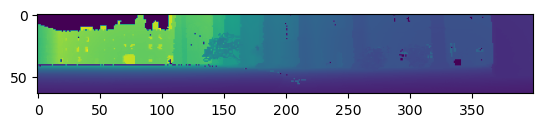

In [4]:
temp = np.zeros([np.shape(images)[1],0])
print(np.shape(temp))
for img_i in range(0,50):
    temp = np.append(temp,images[img_i,:,:,0], axis = 1)

fig, ax = p.subplots()
ax.imshow(temp)

# # # #get some window in our test
testimg = images[12]
testpose = poses[12]

# Train NeRF using old single-network strategy

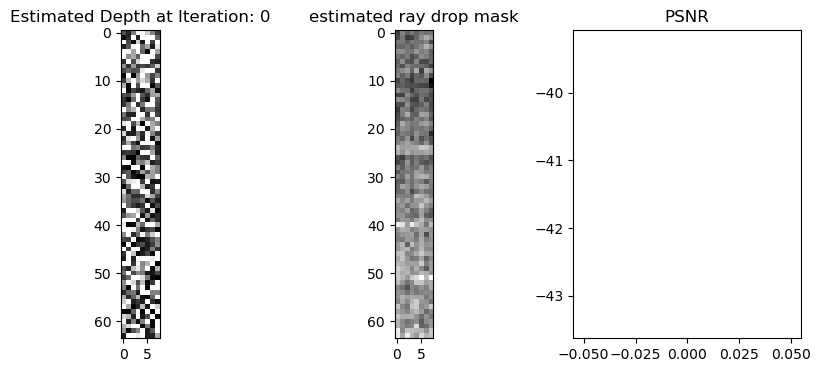

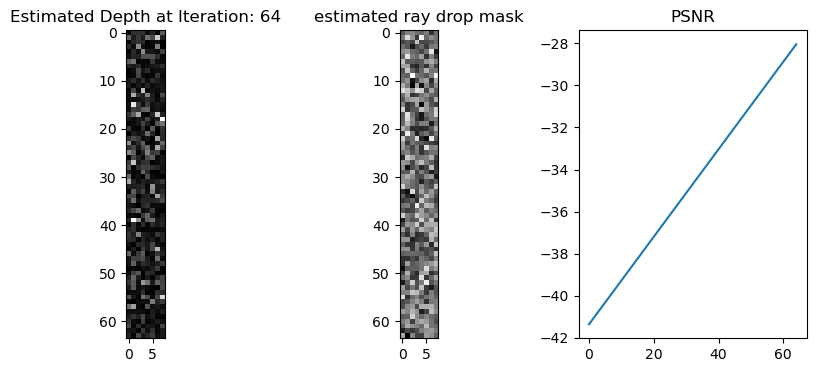

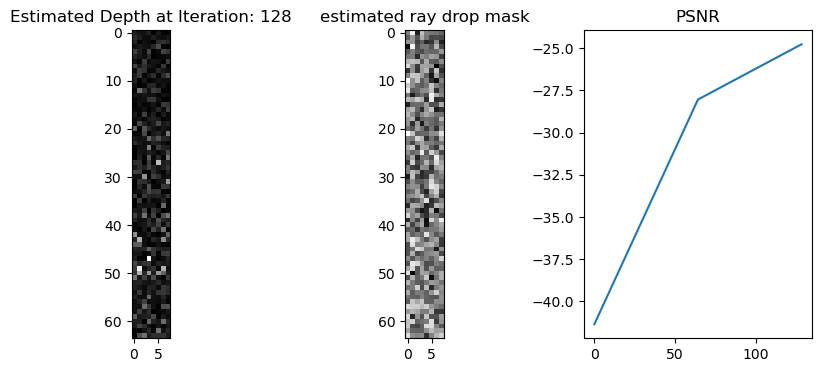

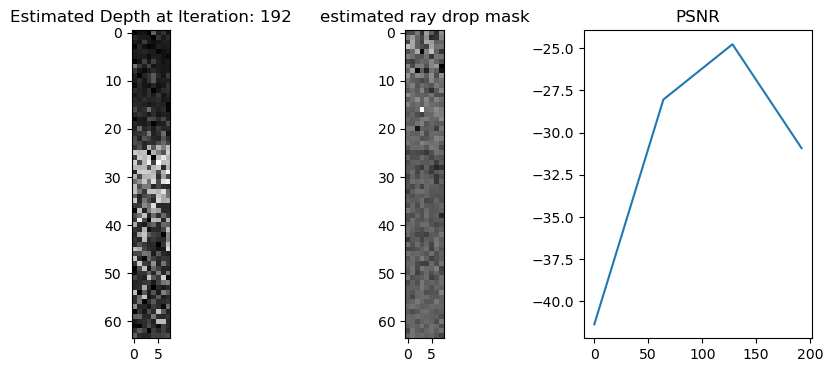

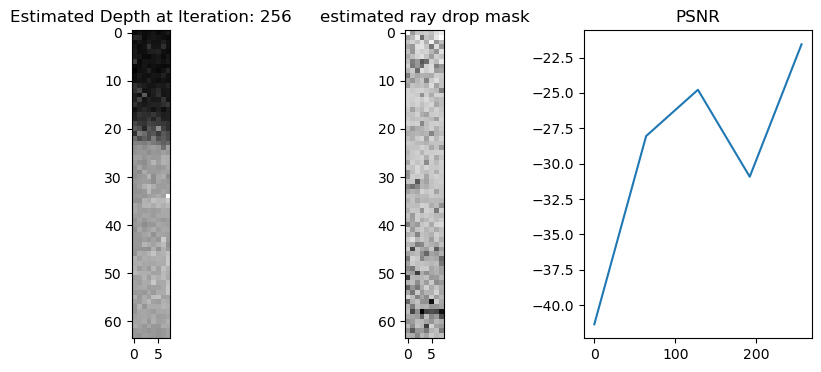

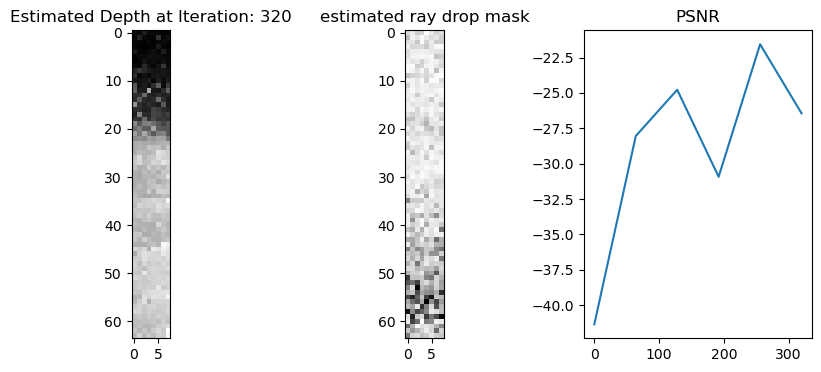

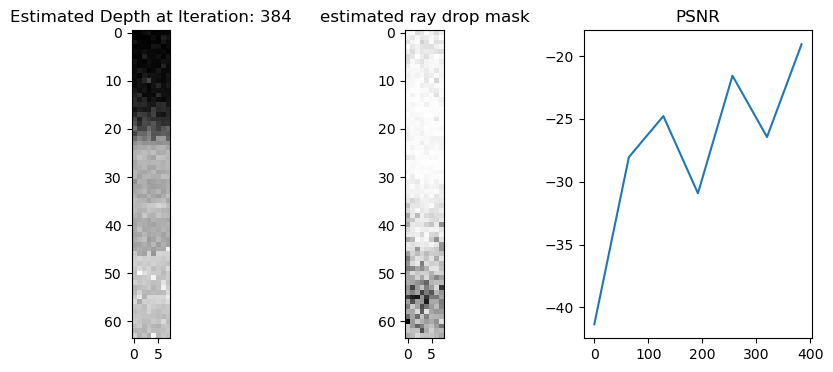

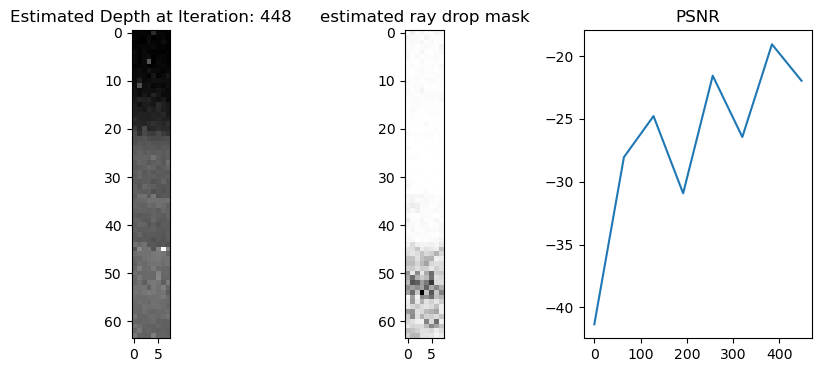

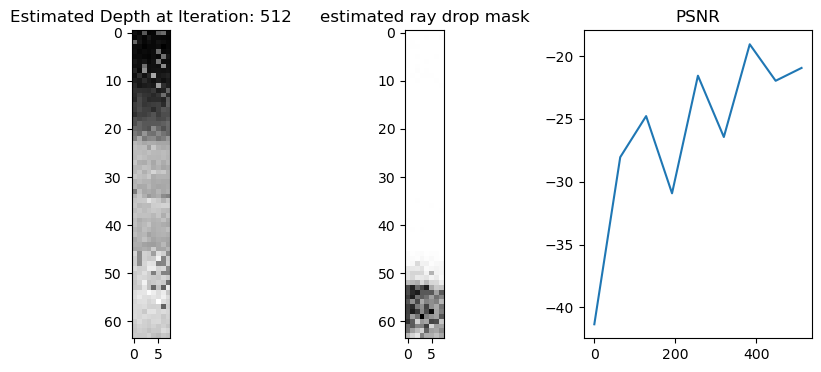

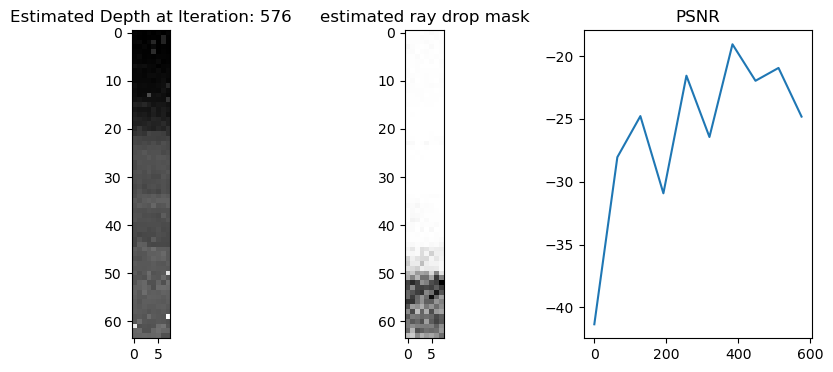

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_19133/2625938631.py", line 50, in <cell line: 37>
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
  File "/home/derm/ASAR/v3/nerf/lidar_nerf_utils.py", line 231, in get_rays
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
  File "/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 2124, in

In [410]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128
near=0.
far=1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 64
accumulate_gradients_steps = 1 #32
# runfine = True
runfine = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
#     print(i)
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]

    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#         z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) #punish similar depth returns
        loss = loss_coarse
        
#         print("z_vals:", tf.shape(z_vals))
        
        if runfine:
            # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
            #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
            #TEST-- slightly wider blur-pool
            fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
            rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
            fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
            rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

    
            #blur-pool as vectorized operation
            test2 = (fwd_test + rev_test) /2 #blur
    #         test2 += 1/N_samples #shift up slightly
            test2 += 1/(3*N_samples) #shift up slightly
            test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
            
            cum_hist_vals = np.cumsum(test2, axis = -1)
            cum_hist_vals_flat = cum_hist_vals.flatten()
    
            #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
            step_corr = np.linspace(0,W*H-1,W*H)
            step_corr = np.tile(step_corr,(N_samples,1)).T
            step_corr = np.reshape(step_corr, [1,-1])[0,:]
            cum_hist_vals_flat+= step_corr
    
            linear_spaced = np.linspace(near, H*W, N_samples*H*W)
#             #fix spacing-- go all the way through [min, max] on every channel???
#             linear_spaced = np.linspace(near, far, N_samples)
#             linear_spaced = np.tile(linear_spaced, (H*W))
#             linear_spaced += step_corr

            ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
            ans -= step_corr
            ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
            ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
            z_vals = np.reshape(ans, [H,W,N_samples,1])
            
            gtCDF = z_vals[:,:,:,0] > target[:,:,:]
            gtCDF = tf.cast(gtCDF, tf.float32)
            
            #run actual 2nd pass through same network
            depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
            depth = depth[:,:,None]
            depth = tf.cast(depth, tf.float32) #why do I have to cast this here???
            ray_drop = ray_drop[:,:,None]

            # loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
            loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
            loss = 0.1*loss_coarse + 0.9*loss_fine 
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

        # #OLD-- not working with CDF stuff
        # current_gradients = tape.gradient(loss, model.trainable_variables)
        # gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
#         depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
#         depth, acc, ray_drop, weights, d1, d2 = render_rays(model, rays_o, rays_d,  z_vals)
        # depth, ray_drop, CDF = render_rays(model, rays_o, rays_d,  z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        # loss = calculate_loss(depth, ray_drop, target, target_drop_mask)
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
#         p.imshow(testimg[:,:,1],cmap = "gray") #, norm='log')
#         p.title(f'Actual Mask at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        #look at depth map
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

# Infer cloud at novel frame

In [411]:
num_view = 128 #128 #number of (rotational?) patches to draw
N_samples = 256 #128 #2048 #does not have to match what was used in training
near=0.
far= 1. #0.25 #2.
n_rots = 128 #128 #number |of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #observed in raw data
phimax = np.deg2rad(17.743)
# phimin = np.deg2rad(-17.743) #TEST
# phimax = np.deg2rad(15.593) #TEST
# phimin = np.deg2rad(-16) #TEST
# phimax = np.deg2rad(16) #TEST
# phimin = np.deg2rad(-5) #test -- trying flipped sign first
# phimax = np.deg2rad(25)  #test

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save poitn cloud to external file

very_beginning = time.time()

for j in range(num_view):
# for j in range(12,116):
    before = time.time()
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots)
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#     #need to account for the fact that the LIDAR beam isn't actually centered at horizon
#     sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
#     #main courtyard
#     rotm[2,-1] = 0.325  #x in world frame output
#     rotm[0,-1] = 0.008 #z in world frame output
#     rotm[1,-1] = 0.325  #y in world frame
    rotm[2,-1] = 0.45  #x in world frame output
    rotm[0,-1] = 0.01 #z in world frame output
    rotm[1,-1] = 0.40  #y in world frame
#     rotm[2,-1] = 0.2656  #x in world frame output     #starting orientation
#     rotm[0,-1] = 0.006 #0.0086 #z in world frame output
#     rotm[1,-1] = 0.3254  #y in world frame
# #     #forest
#     rotm[2,-1] = 0.299  #x in world frame output
#     rotm[0,-1] = 0.012 #z in world frame output
#     rotm[1,-1] = 0.365  #y in world frame

    rotm = rotm.astype(np.float32)
    
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     print(phimin_patch, phimax_patch)
    
    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    elapsed = time.time() - before
#     print("1 forward pass took ", elapsed, "s")
    begin_other = time.time()
    
    #~~~~~~~~~~~
    #run fine pass through network
    fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
    rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
    fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
    rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
#     fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
#     rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
#     fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
#     rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)
    test2 = (fwd_test + rev_test) /2 #blur
    test2 += 1/(3*N_samples) #shift up slightly
    test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
    cum_hist_vals = np.cumsum(test2, axis = -1)
    randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
    cum_hist_vals_flat = cum_hist_vals.flatten()
    step_corr = np.linspace(0,W*H-1,W*H)
    step_corr = np.tile(step_corr,(N_samples,1)).T
    step_corr = np.reshape(step_corr, [1,-1])[0,:]
    cum_hist_vals_flat+= step_corr
    linear_spaced = np.linspace(near, H*W, N_samples*H*W)
    #fix spacing-- go all the way through [min, max] on every channel???
#     linear_spaced = np.linspace(near, far, N_samples)
#     linear_spaced = np.tile(linear_spaced, (H*W))
#     linear_spaced += step_corr
    ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
#     print(ans)
    ans -= step_corr
    ans *= far
    ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
    z_vals = np.reshape(ans, [H,W,N_samples,1])
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    #~~~~~~~~~~~
        
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= 200 #200 #50 #200
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(np.shape(images)[1] - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
#     new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #flip another axis to get back to LHCS (synthetic data only?)

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 2, alpha = 0.5))
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
#     print("took ", time.time() - begin_other, "s to do the rest")

#get rid of points at origin
d = np.sqrt(np.sum(savepc**2, axis = 1))
print(np.shape(d))
good  = np.argwhere(d > 1)[:,0]
savepc = savepc[good]


print("took: ", time.time() - very_beginning,"s overall")
# print(testpose)
# print("\n", rotm)
plt.show(disp, "Old Coarse-to-Fine on Single Network")
ViewInteractiveWidget(plt.window)

(65536,)
took:  11.942582130432129 s overall


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Test creating arbitrary bins for coarse and fine network outputs

### Left Riemann Sum

In [7]:
n_bins_coarse = 7
bins_coarse = np.linspace(0,1,n_bins_coarse)
# bins_coarse = bins_coarse**2#TEST
w_coarse = np.gradient(bins_coarse)
print(bins_coarse)
print(w_coarse)
w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667]


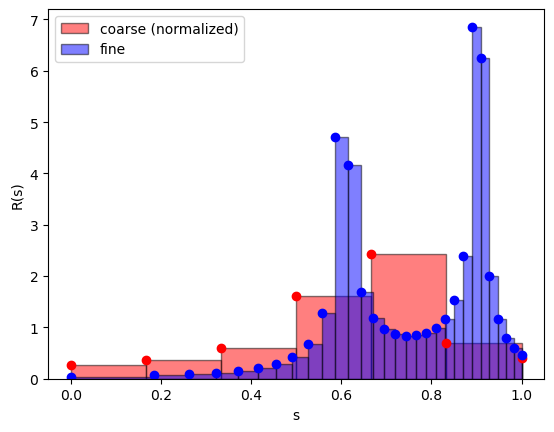

In [8]:
from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse+w_coarse/2, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
ax.bar(bins_fine+w_fine/2, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

In [9]:
#Calculate loss for a given region in the coarse histogram
# print(bins_coarse)
# print(bins_fine)
# print(np.sum(vals_coarse), np.sum(vals_fine))

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution
    small_enough_idx = np.where(bins_fine < bins_coarse[i+1])
    big_enough_idx = np.where(bins_fine >= bins_coarse[i])
    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i]*w_coarse[i])
#     print("val fine in bin i:", fine_in_bin)
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.08316307909254511
L[i] 0.0
L[i] 0.29248224272919776
0.3756453218217429


### With centered bins

bins_coarse:
 [0.05555556 0.16666667 0.27777778 0.38888889 0.5        0.61111111
 0.72222222 0.83333333 0.94444444 1.        ]
w_coarse:
 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.        ]
L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.04748683492396345
L[i] 0.10796507658317803
L[i] 0.26277499198763676
0.41822690349477826


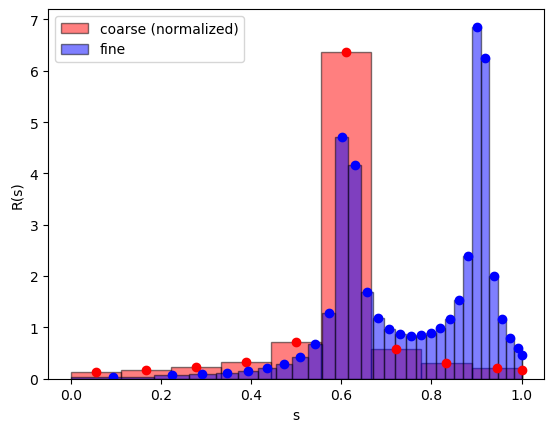

In [10]:
n_bins_coarse = 10
bins_coarse = np.linspace(0,1,n_bins_coarse)

# # bins_coarse = bins_coarse**2
# bins_coarse = np.cumsum(abs(np.sin(10*bins_coarse)))
# bins_coarse /= bins_coarse[-1]

w_coarse = np.diff(bins_coarse)
w_coarse = np.append(w_coarse, 0)
bins_coarse = bins_coarse+w_coarse/2
# w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

print("bins_coarse:\n", bins_coarse)
print("w_coarse:\n", w_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
bins_fine = bins_fine+w_fine/2
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
ax.bar(bins_fine, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution    
#     print(bins_coarse[i]-(w_coarse[i]/2), (bins_coarse[i]+(w_coarse[i+1]/2)))
    small_enough_idx = np.where(bins_fine < (bins_coarse[i]+(w_coarse[i+1]/2)))
    big_enough_idx = np.where(bins_fine >= bins_coarse[i]-(w_coarse[i]/2))

    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i]*w_coarse[i])
#     print("val fine in bin i:", fine_in_bin)
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

# Recreating the above process in parallel using tensorflow

In [307]:
import tensorflow_probability as tfp
#make arbitrary fine distributions (what the fine netork of the scene)
#  these vary in inferred density as well as sampling location
H = 64
W = 8
n_bins_fine = 64
n_bins_coarse = 16

#create random sinusoidal peaks
randy = np.pi*tf.random.uniform([H,W, 2])
randy2 = np.pi*tf.cast(tf.random.uniform([H,W, 2]),tf.float32) 

# print(np.shape(randy))
lin = tf.cast(tf.linspace(0,1,n_bins_fine), tf.float32)
lin = tf.tile(lin[None,None,:,None], [H,W,1,1])
weights_fine = (tf.math.sin(randy[...,:1,None]*np.pi*lin + randy[...,1:2,None]) +1)/2

z_vals_coarse = tf.cast(tf.linspace(0,1,n_bins_coarse), tf.float32)
#TEST -- nonlinear z values for coarse network -- looks like it works!
# z_vals_coarse = z_vals_coarse**2 
# z_vals_coarse = tf.math.sin(z_vals_coarse)
z_vals_coarse = tf.tile(z_vals_coarse[None,None,:,None], [H,W,1,1])
# print(np.shape(z_vals_coarse))
weights_coarse = (tf.math.sin(randy[...,:1,None]*np.pi*z_vals_coarse + randy[...,1:2,None]) +1)/2
weights_coarse = weights_coarse/tf.math.reduce_sum(weights_coarse, axis = 2)[:,:,:,None] #normalize to sum to 1
# print(np.shape(weights_coarse))
# print(np.shape(weights_fine))

w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001)
#shift definition of z_vals to the center (for centered Riemann Sums)

#init z_vals [h, w, n_samples, 1]
#create inconsistant spacing for z vals in fine rays
#same as "bins_fine" in previous
z_vals_fine = (tf.math.sin(3*np.pi*randy2[...,:1,None]*lin + randy2[...,1:,None]) + 2 ) /3
# z_vals = (tf.math.sin(np.pi*randy2[:,:1]*lin + randy2[:,1:]) + 1 ) /2
z_vals_fine = tf.cumsum(z_vals_fine, axis = -2)
# print("z_vals", np.shape(z_vals))
z_vals_fine -= z_vals_fine[:,:,:1,:]
z_vals_fine /= z_vals_fine[:,:,-1:,:]
# print("test", np.shape(z_vals_fine[:,:,-1:,:]))
# print(z_vals[0,0,:,0])


w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)

#shift z_vals def to the center
z_vals_coarse = z_vals_coarse + w_coarse/2 
z_vals_fine = z_vals_fine + w_fine/2 

# #TEST -- renormalize fine widths ~~~~~~~
# w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
# padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
# w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#correct weights so area under the curve is 1
area_fine = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)[:,:,:,None]
weights_fine = weights_fine/area_fine
# print(tf.math.reduce_sum(weights_fine*w_fine, axis = 2))

area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse, axis =2)[:,:,:,None]
weights_coarse = weights_coarse/area_coarse
# print(tf.math.reduce_sum(weights_coarse*w_coarse, axis = 2))

print(w_coarse[0,0,:,0])
print(tf.experimental.numpy.diff(z_vals_coarse, axis = 2)[0,0,:,0]) #<--- slightly different at very end

tf.Tensor(
[0.06666667 0.06666667 0.06666666 0.06666668 0.06666666 0.06666666
 0.06666666 0.06666669 0.06666666 0.06666666 0.06666666 0.06666666
 0.06666666 0.06666666 0.06666666 0.001     ], shape=(16,), dtype=float32)
tf.Tensor(
[0.06666668 0.06666666 0.06666668 0.06666666 0.06666666 0.06666666
 0.06666666 0.06666672 0.0666666  0.06666672 0.0666666  0.06666672
 0.0666666  0.06666672 0.03383327], shape=(15,), dtype=float32)


In [308]:
def my_gradient_tf(a):
    rght = tf.concat((a[..., 1:], tf.expand_dims(a[..., -1], -1)), -1)
    left = tf.concat((tf.expand_dims(a[...,0], -1), a[..., :-1]), -1)
    ones = tf.ones_like(rght[..., 2:], tf.float32)
    one = tf.expand_dims(ones[...,0], -1)
    divi = tf.concat((one, ones*2, one), -1)
#     print(left[0,0,:])
#     print(rght[0,0,:])

    test = tf.concat((a[...,1:], tf.ones_like(a[:,:,:1])), axis = -1) - a
    print(test[0,0,:])
    
    return (rght-left) / divi

g = my_gradient_tf(z_vals_coarse[:,:,:,0])
print(g[0,0,:])

tf.Tensor(
[ 0.06666668  0.06666666  0.06666668  0.06666666  0.06666666  0.06666666
  0.06666666  0.06666672  0.0666666   0.06666672  0.0666666   0.06666672
  0.0666666   0.06666672  0.03383327 -0.00049996], shape=(16,), dtype=float32)
tf.Tensor(
[0.06666668 0.06666667 0.06666667 0.06666667 0.06666666 0.06666666
 0.06666666 0.06666669 0.06666666 0.06666666 0.06666666 0.06666666
 0.06666666 0.06666666 0.05024999 0.03383327], shape=(16,), dtype=float32)


fine_sum: tf.Tensor(
[1.4231943  1.9258438  1.5889064  0.84479713 0.94115335 0.584904
 0.3020235  0.12504646 0.0124462  0.13067724 0.49675697 1.3406363
 1.6051323  2.111521   1.5446144  1.4898251 ], shape=(16,), dtype=float32)
L_i: 0.1770069
L_along_ray scaled 
 tf.Tensor(
[-0.          0.0273218   0.03021025  0.00861953  0.04008896  0.03337506
  0.02011537  0.00135246 -0.         -0.         -0.         -0.
 -0.          0.01591198 -0.          0.00001148], shape=(16,), dtype=float32)


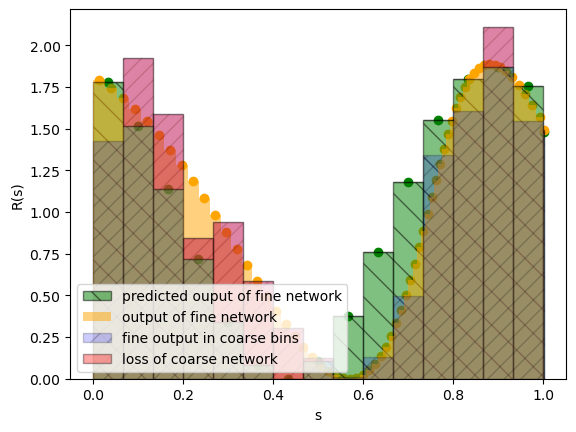

In [312]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~
look_at = 0

#left riemann sums (old)
# zc = z_vals_coarse[look_at,0,:,0] 
zf = z_vals_fine[look_at,0,:,0]
#shift for centered riemann sums -- see if center of fine fits within left and right limits of coarse 
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2 
zf = z_vals_fine[look_at,0,:,0]

# print("zc \n", zc)
# print("zf \n", zf)

#get index of which bin in coarse each bar in fine belongs inside of
indices = tf.searchsorted(zc, zf, side='right')-1
# print("idx: \n", indices)

#need to scale L_i by width of coarse bins
fine_sum = tf.math.segment_sum(weights_fine[look_at,0,:,0]*w_fine[look_at,0,:,0], indices)/w_coarse[look_at,0,:,0]
mask = tf.cast(fine_sum > weights_coarse[look_at,0,:,0], tf.float32)
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]))
L_along_ray = mask*((fine_sum-weights_coarse[look_at,0,:,0])) #don's scale (for plotting only)

print("fine_sum:", fine_sum)
# print("mask:", mask)
print("L_i:", L_i.numpy())
print("L_along_ray scaled \n", L_along_ray*w_coarse[look_at,0,:,0])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, ax = p.subplots()

ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0], color  = 'green')
ax.scatter(z_vals_fine[0,0,:,0],  weights_fine[0,0,:,0], color = 'orange')
# ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0] *  (n_bins_coarse/n_bins_fine) )
#     ax.scatter(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
#     ax.plot(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
# ax.bar(z_vals_coarse[0,j,:,0]+w_coarse[0,j,:,0]/2, weights_coarse[0,j,:,0], width = w_coarse[0,j,:,0], 
#    label = "coarse (scaled)", edgecolor = 'black', alpha = 0.5);
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:,0], width = w_fine[look_at,0,:,0], 
   label = "output of fine network", alpha = 0.5, color = 'orange') #, edgecolor = 'black');
ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum, width = w_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);

# #stacked bar chart for loss
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray,
       width = w_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0] ,
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc = 'lower left')
# print("fine_sum", fine_sum)
# print(fine_sum > weights_coarse[0,0,:,0])

In [310]:
print(tf.math.reduce_sum(w_coarse[look_at,0,:]))
print(tf.math.reduce_sum(w_fine[look_at,0,:]))

tf.Tensor(1.0009999, shape=(), dtype=float32)
tf.Tensor(1.0009999, shape=(), dtype=float32)


In [318]:
#DEBUG: why are center reimann sums producing different results?

def safe_segment_sum(data, segment_ids, num_segments):
    # Initialize an array to store the segment sums
    segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
    # Compute the segment sums using tensor_scatter_nd_add
    segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
    return segment_sums

i = 0
j = 0

# print(z_vals_coarse[0,0])
# print(w_coarse[0,0]/2)

zc = z_vals_coarse[i,j,:,0] - w_coarse[i,j,:,0]/2 
zf = z_vals_fine[i, j,:,0]
wc = weights_coarse[i, j,:,0]
wf = weights_fine[i, j,:,0]
width_fine_for_ray = w_fine[i,j,:,0] 
width_coarse_for_ray = w_coarse[i,j,:,0]

idx = tf.searchsorted(zc, zf, side='right') - 1
# print(idx)
# print(wf*width_fine_for_ray)
# print(len(zc))

fine_sum = safe_segment_sum(wf*width_fine_for_ray, idx, len(zc))/width_coarse_for_ray   
print("fine_sum \n", fine_sum)

mask = tf.cast(fine_sum > wc , tf.float32)
print("mask \n", mask)

# L_i = tf.math.reduce_sum(mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]) #scale by coarse bin widths 
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j,:,0])*w_coarse[i,j,:,0]))
print("L_i \n", L_i)
# print("weights_coarse[i,j]", weights_coarse[i,j,:,0])
# print("w_coarse", w_coarse[i,j,:,0])

fine_sum 
 tf.Tensor(
[1.4231943  1.9258438  1.5889064  0.84479713 0.94115335 0.584904
 0.3020235  0.12504646 0.0124462  0.13067724 0.49675697 1.3406361
 1.6051323  2.111521   1.5446144  1.4898251 ], shape=(16,), dtype=float32)
mask 
 tf.Tensor([0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.], shape=(16,), dtype=float32)
L_i 
 tf.Tensor(0.1770069, shape=(), dtype=float32)


In [314]:
def calculate_loss_coarse_network(z_vals_coarse, z_vals_fine, weights_coarse, weights_fine):
    '''Calculate loss for coarse network. Given histograms for scene density outptut by fine network,
    see how close the density estimated by the coarse network got us.'''
    
    def safe_segment_sum(data, segment_ids, num_segments):
        # Initialize an array to store the segment sums
        segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
        # Compute the segment sums using tensor_scatter_nd_add
        segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
        return segment_sums
    
#     print("\n calculate loss coarse network \n")
#     print(" z_vals_coarse \n", np.shape(z_vals_coarse))
#     print(" z_vals_fine \n", np.shape(z_vals_fine))
#     print(" weights_coarse \n",np.shape(weights_coarse))
#     print(" weights_fine\n",np.shape(weights_fine))
    
    def run_on_ray(index): 
        i, j = index
#         zc = z_vals_coarse[i, j]
        zc = z_vals_coarse[i,j] - width_coarse[i,j]/2 
#         zc = z_vals_coarse[i,j] - w_coarse[i,j,:,0]/2 
#         print("zc: ", zc)
        zf = z_vals_fine[i, j]
        wc = weights_coarse[i, j]
        wf = weights_fine[i, j]
#         width_fine_for_ray = w_fine[i,j,:,0] 
#         width_coarse_for_ray = w_coarse[i,j,:,0]
        width_fine_for_ray = width_fine[i,j] 
        width_coarse_for_ray = width_coarse[i,j]            
    
        # Get index of which bin in coarse each bar in fine belongs inside of
        idx = tf.searchsorted(zc, zf, side='right') - 1

#         fine_sum = tf.math.segment_sum(wf*width_fine_for_ray, idx)/width_coarse_for_ray
        fine_sum = safe_segment_sum(wf*width_fine_for_ray, idx, len(zc))/width_coarse_for_ray        
        mask = tf.cast(fine_sum > wc , tf.float32)
#         L_i = tf.math.reduce_sum(mask*(fine_sum-wc)) #old
#         L_i = tf.math.reduce_sum(mask*(fine_sum-wc)*w_coarse) #scale by coarse bin widths 
#         L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j,:,0])*w_coarse[i,j,:,0]))
        L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j])*w_coarse[i,j,:,0]))

        if i == 0 and j == 0:
#             print("\n zc \n", zc)
#             print("loss along ray: \n", mask*(fine_sum-wc)*width_coarse_for_ray)
#             print("fine_sum: \n", fine_sum)
#             print("L_i \n", L_i)
#             print("mask \n", mask)
#             print("weights_coarse[i,j] \n", weights_coarse[i,j])
            print("w_coarse[i,j] \n", w_coarse[i,j,:,0]) #for some reason it works if we use this (generated externally)
#             print(np.shape(width_coarse))
#             print("idx: \n", idx) #looks like a match so far...
#             print("zc", np.shape(zc))
#             print("z_vals_coarse", np.shape(z_vals_coarse))
#             print("width_coarse", np.shape(width_coarse))
#             print("w_coarse", np.shape(w_coarse))
            
        return L_i
    
    #get spacing between subsequent z measurements in z_vals_fine to weight contributions
    width_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
#     print(np.shape(width_fine))
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_fine = tf.pad(width_fine, padding_config, constant_values=0.001)
#     print(np.shape(width_fine))
    
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2) #not quite??
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_coarse = tf.pad(width_coarse, padding_config, constant_values=0.001)
#     print(np.shape(width_coarse))
    print("width_coarse[i,j]", width_coarse[i,j])

    #normalize coarse and fine to contain an area of 1
#     area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse[:,:,:,0], axis =2)[:,:,None]
#     print("width_coarse", np.shape(width_coarse))
    area_coarse = tf.math.reduce_sum(weights_coarse * width_coarse, axis =2)[:,:,None]
    weights_coarse = weights_coarse/area_coarse
#     area_fine = tf.math.reduce_sum(weights_fine * w_fine[:,:,:,0], axis =2)[:,:,None]
    area_fine = tf.math.reduce_sum(weights_fine * width_fine, axis =2)[:,:,None]
    weights_fine = weights_fine/area_fine
    #print(tf.math.reduce_sum(weights_coarse * w_coarse[:,:,:,0], axis = 2)) #will be all ones if norm'd correctly
    #print(tf.math.reduce_sum(weights_fine * w_fine[:,:,:,0], axis = 2)) #will be all ones if norm'd correctly

    #map over each batch dimension
    indices = tf.stack(tf.meshgrid(tf.range(z_vals_coarse.shape[0]), tf.range(z_vals_coarse.shape[1]), indexing='ij'), axis=-1)
    indices = tf.reshape(indices, (-1, 2))
    
    # Use tf.map_fn to apply the run_on_ray() in parallel over batch dimensions    
    L = tf.map_fn(run_on_ray, indices, fn_output_signature=tf.float32)
    L = tf.reshape(L, (z_vals_coarse.shape[0], z_vals_coarse.shape[1]))
    
    return L

L = calculate_loss_coarse_network(z_vals_coarse[...,0], z_vals_fine[...,0], weights_coarse[...,0], weights_fine[...,0])
print(L[0,0])

width_coarse[i,j] tf.Tensor(
[0.06666668 0.06666666 0.06666668 0.06666666 0.06666666 0.06666666
 0.06666666 0.06666672 0.0666666  0.06666672 0.0666666  0.06666672
 0.0666666  0.06666672 0.03383327 0.001     ], shape=(16,), dtype=float32)
w_coarse[i,j] 
 tf.Tensor(
[0.06666667 0.06666667 0.06666666 0.06666668 0.06666666 0.06666666
 0.06666666 0.06666669 0.06666666 0.06666666 0.06666666 0.06666666
 0.06666666 0.06666666 0.06666666 0.001     ], shape=(16,), dtype=float32)
tf.Tensor(0.19261253, shape=(), dtype=float32)


In [319]:
from coarse_network_utils import * 

fast = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0] - w_coarse[:,:,:,0]/2, z_vals_fine[:,:,:,0], 
                                     weights_coarse[:,:,:,0], weights_fine[:,:,:,0],
                                     w_coarse[:,:,:,0], w_fine[:,:,:,0] )
print("fast: \n", np.shape(fast), fast[0,0])

fast: 
 (64, 8) tf.Tensor(0.17700686, shape=(), dtype=float32)


# Upsampling from coarse to fine distribution

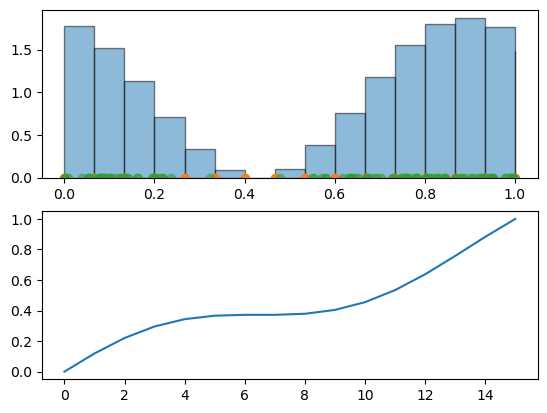

In [320]:
look_at = 0 #0
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2
zf = z_vals_fine[look_at,0,:,0]
wc = weights_coarse[look_at,0,:,0]
wf = weights_fine[look_at,0,:,0]
width_coarse = w_coarse[look_at,0,:,0]
width_fine = w_fine[look_at,0,:,0]

fig, ax = p.subplots(2,1)
ax[0].bar(zc + width_coarse/2, wc, width = width_coarse, 
   label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax[0].scatter(zc,  tf.zeros_like(wc))

n_resample = 100
wc = tf.pad(wc[:,None], [[1,0], [0,0]] )[:-1,0]
# print(wc)
wc_cdf = tf.math.cumsum(wc/tf.math.reduce_sum(wc))
# print("wc_cdf: \n", wc_cdf.numpy())
randy = tf.sort(tf.random.uniform([n_resample]))
# print("randy: \n ", randy.numpy())
idx = tf.searchsorted(wc_cdf, randy, side='right')
# print("idx: \n", idx)

cdf_left = tf.gather(wc_cdf, idx - 1)
# print("cdf_left:\n", cdf_left.numpy())
cdf_right = tf.gather(wc_cdf, idx)
values_left = tf.gather(zc, idx - 1)
# print("values_left:\n", values_left.numpy())
values_right = tf.gather(zc, idx)

weights = (randy - cdf_left) / (cdf_right - cdf_left)
# print("weights \n", weights)
continuous_samples = values_left + weights * (values_right - values_left)
# print(continuous_samples)

ax[1].plot(wc_cdf)
ax[0].scatter(continuous_samples, tf.zeros_like(continuous_samples), alpha = 0.5)

tf.Tensor(
[0.         0.06666668 0.13333334 0.20000002 0.26666668 0.33333334
 0.4        0.46666664 0.5333334  0.6        0.66666675 0.73333335
 0.8000001  0.8666667  0.9333334  0.99999994], shape=(16,), dtype=float32)


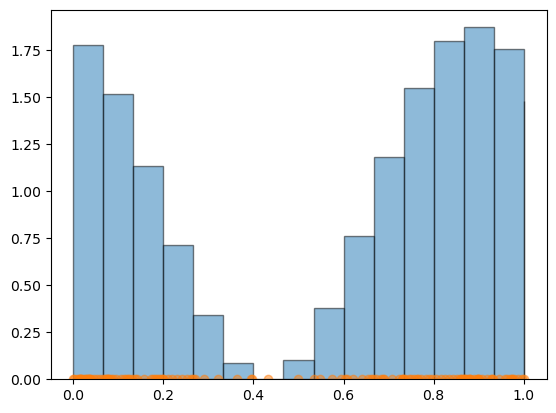

In [321]:
from coarse_network_utils import resample_z_vals

continuous_samples, width_z = resample_z_vals(z_vals_coarse - w_coarse/2, weights_coarse, w_coarse)
print(z_vals_coarse[0,0,:,0] - w_coarse[0,0,:,0]/2)

fig, ax = p.subplots()
look_at = 0
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(continuous_samples[look_at,0,:], tf.zeros_like(continuous_samples[look_at,0,:]), alpha = 0.5)

# ax.plot(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:]) #/tf.math.reduce_sum(weights_fine[0,0,:]*np.gradient(z_vals_fine[0,0,:,0])))

In [322]:
print(tf.math.reduce_sum(continuous_samples))

tf.Tensor(29561.078, shape=(), dtype=float32)


# Train Dual Networks


 iteration: 0
loss_coarse: tf.Tensor(0.91066116, shape=(), dtype=float32)
loss_fine: tf.Tensor(8.164061, shape=(), dtype=float32)
L along ray tf.Tensor(
[ 0.91066116 -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


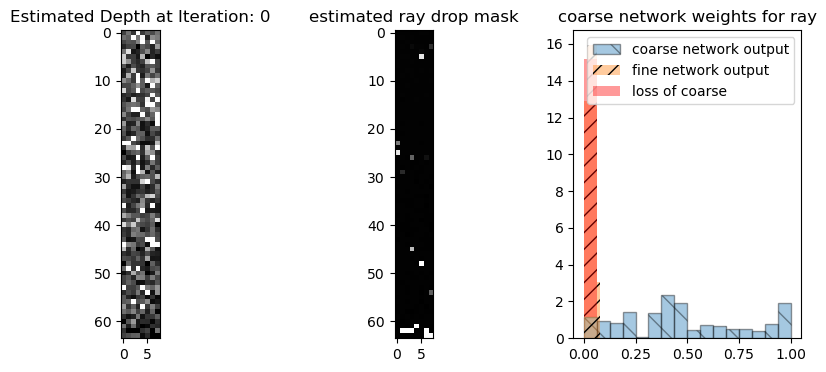


 iteration: 50
loss_coarse: tf.Tensor(0.8904257, shape=(), dtype=float32)
loss_fine: tf.Tensor(23.591345, shape=(), dtype=float32)
L along ray tf.Tensor(
[ 0.45067763  0.43974808 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


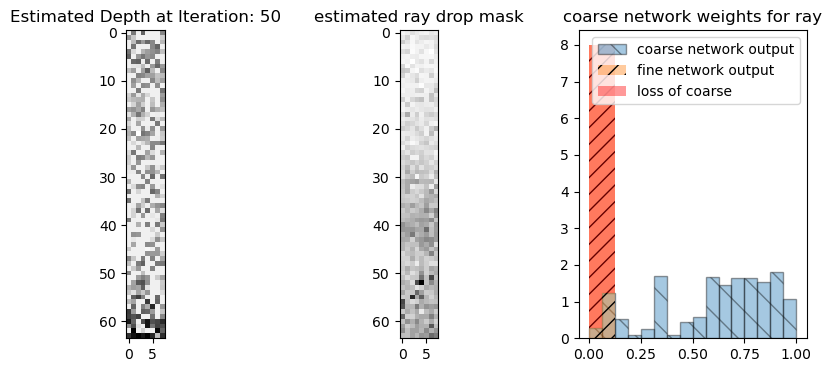


 iteration: 100
loss_coarse: tf.Tensor(0.93360716, shape=(), dtype=float32)
loss_fine: tf.Tensor(18.220215, shape=(), dtype=float32)
L along ray tf.Tensor(
[-0.         -0.          0.93360716 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


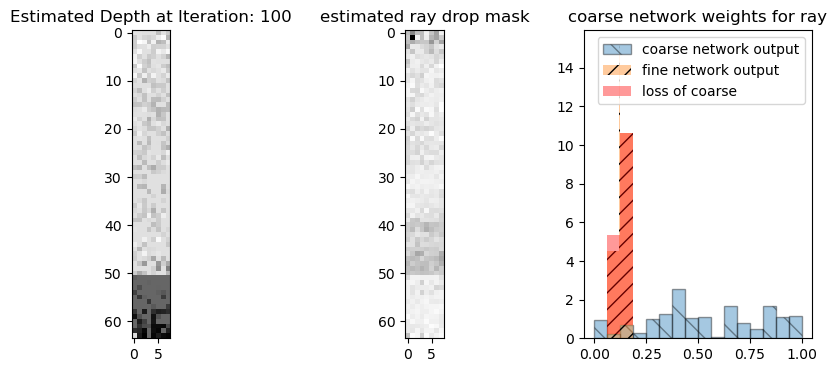


 iteration: 150
loss_coarse: tf.Tensor(0.98611337, shape=(), dtype=float32)
loss_fine: tf.Tensor(16.340485, shape=(), dtype=float32)
L along ray tf.Tensor(
[-0.          0.98611337 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


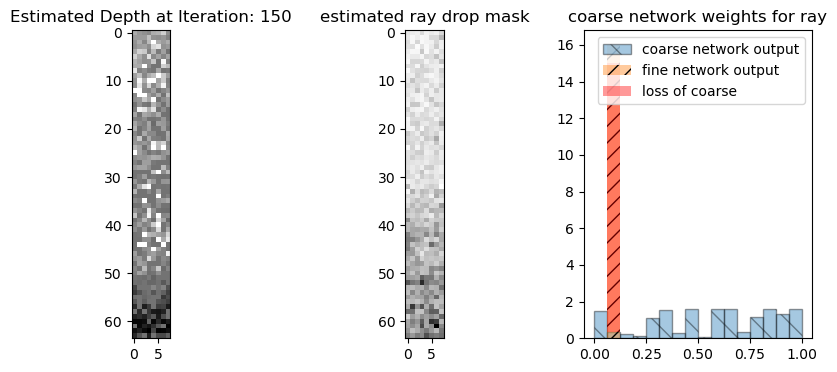


 iteration: 200
loss_coarse: tf.Tensor(0.9121238, shape=(), dtype=float32)
loss_fine: tf.Tensor(12.45043, shape=(), dtype=float32)
L along ray tf.Tensor(
[ 0.9121238 -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.       ], shape=(16,), dtype=float32)


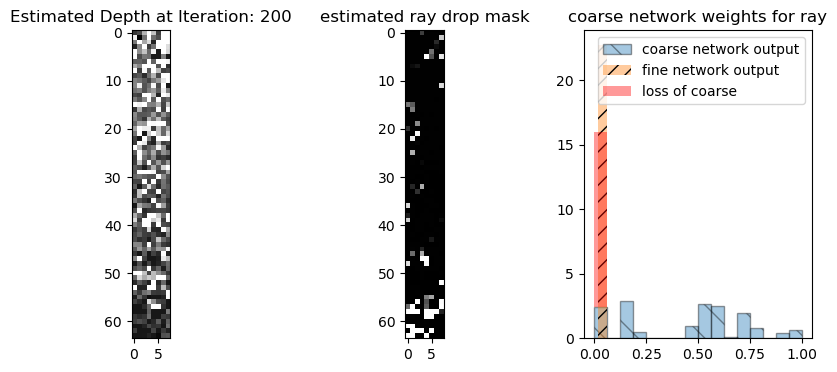


 iteration: 250
loss_coarse: tf.Tensor(0.99944186, shape=(), dtype=float32)
loss_fine: tf.Tensor(60.13583, shape=(), dtype=float32)
L along ray tf.Tensor(
[ 0.638065    0.36137685 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


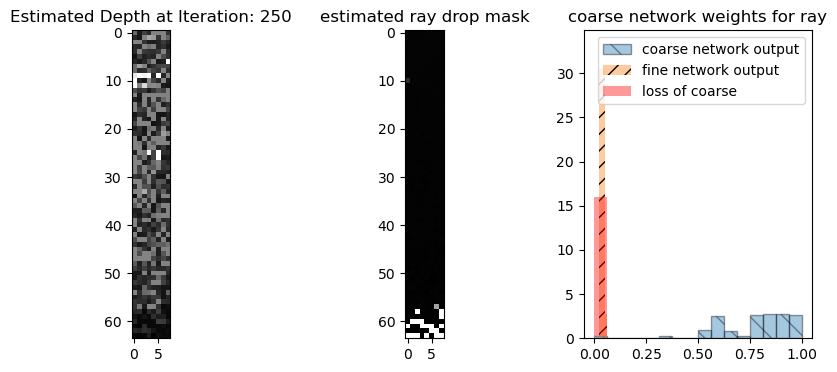


 iteration: 300
loss_coarse: tf.Tensor(0.8033721, shape=(), dtype=float32)
loss_fine: tf.Tensor(53.826622, shape=(), dtype=float32)
L along ray tf.Tensor(
[ 0.8033721 -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.        -0.        -0.
 -0.        -0.        -0.        -0.       ], shape=(16,), dtype=float32)


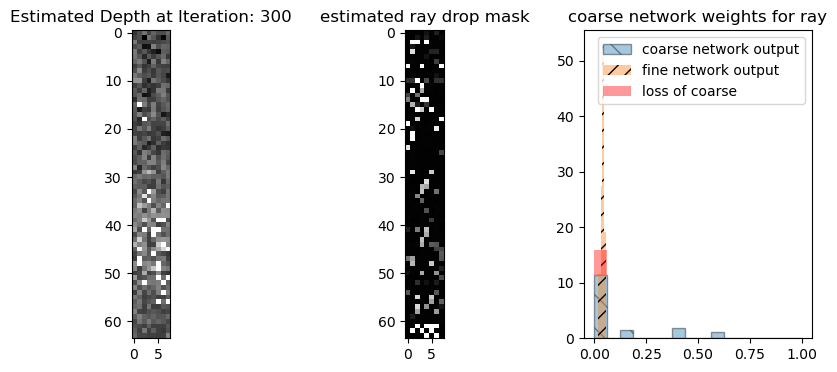


 iteration: 350
loss_coarse: tf.Tensor(0.998154, shape=(), dtype=float32)
loss_fine: tf.Tensor(18.34543, shape=(), dtype=float32)
L along ray tf.Tensor(
[ 0.75554585  0.24260812 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


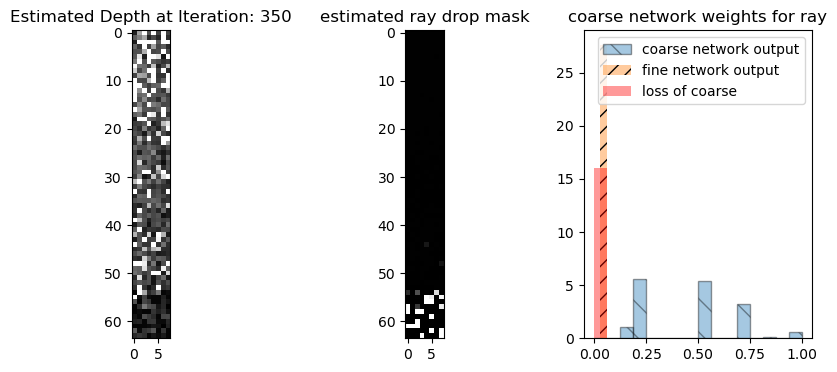

KeyboardInterrupt: 

In [435]:
from lidar_nerf_utils import *
from coarse_network_utils import*

model_coarse = init_model_proposal()
model_fine = init_model()
# # model_fine.load_weights('models/bigV1.ckpt') #load from pre-trained nerf
model_fine = model #warm start from previous training loop

# optimizer_fine = tf.keras.optimizers.Adam(1e-4)
optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
optimizer_fine = tf.keras.optimizers.Adam(1e-4)

n_bins_fine = 32
n_bins_coarse = 16 #16
near=0.
far=1.
N_iters = 10_000 #5_000
psnrs = []
iternums = []
i_plot = 50

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

for i in range(N_iters):
    img_i = np.random.randint(images.shape[0])
#     img_i = 10
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]

    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
#     with tf.GradientTape() as tape_coarse:
        #run coarse network first to get locations to evaluate fine model at ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                         rays_o, rays_d, n_resample = n_bins_fine)    
        
        z_vals_fine = z_vals_fine[:, :, :, None]
                
#         #Stop gradient to prevent backprop through coarse network
        weights_coarse = tf.stop_gradient(weights_coarse[:, :, :, None])
                
        # run fine network to get actual scene density ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
        area_fine = tf.reduce_sum(weights_fine * width_fine, axis=2, keepdims=True)
        weights_fine /= area_fine
        
        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                                z_vals_fine[:,:,:,0], 
                                                                weights_coarse[:,:,:,0], 
                                                                weights_fine, 
                                                                width_coarse[:,:,:,0],
                                                                width_fine[:,:,:],
                                                                debug = True)
        #suppress pixels with ray drop
#         loss_coarse = loss_coarse * target_drop_mask[:,:,0] #WAS THIS
        temp = loss_coarse #* target_drop_mask[:,:,0] #DEBUG
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        
        
        # Compute gradients and apply them
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        
#         if i % i_plot == 0:
#             print("Gradients Coarse:")
#             for grad, var in zip(gradients_coarse, model_coarse.trainable_variables):
#                 print(f"{var.name}: {grad.numpy()}")
        
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))

        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        

        if i % i_plot == 0:
            print("\n iteration:", i)            
            print("loss_coarse:", temp[0,0])
            print("loss_fine:", loss_fine)    
            mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
            L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
            print("L along ray", L_along_ray[0,0,:])
            
#             #rescale weights_coarse before plotting ~~~~~~~~
#             eps = 1e-3 #1e-3
#             weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
#             weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
#             #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            look_at = 32
            p.figure(figsize=(10,4))
            p.subplot(131)
            p.imshow(depth,cmap = "gray")#, norm='log')
            p.title(f'Estimated Depth at Iteration: {i}')
            p.subplot(133)
            p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
                 alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')
            p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
                 alpha = 0.4, label= 'fine network output', hatch = '//')
            p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
                  bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
                  label= 'loss of coarse')    
            p.title('coarse network weights for ray')
            p.legend(loc="best")
            p.subplot(132)
            p.imshow(ray_drop, cmap="gray")#, norm = 'log')
            p.title("estimated ray drop mask")
            p.show()

In [387]:
# has_nans = tf.constant([float('NaN'), 1.])
# print(has_nans)
# has_nans = tf.where(tf.math.is_nan(has_nans), tf.zeros_like(has_nans), has_nans)
# print(has_nans)

In [436]:
#TODO: issue is here??
# Pad weights for CDF computation, removing the first padded value after
wc_padded = tf.pad(weights_coarse[:,:,:,0], [[0, 0], [0, 0], [1, 0]], constant_values=0)[:, :, :-1] #old
# wc_padded = tf.pad(weights_coarse[:,:,:,0], [[0, 0], [0, 0], [0, 1]], constant_values=0)[:, :, :-1] #debug
# wc_padded = weights_coarse[:,:,:,0] #debug
print("wc_padded", wc_padded[0,0,:])
print("wc", weights_coarse[0,0,:,0])

# print("wc_padded max", tf.math.reduce_max(wc_padded))
# print("wc_padded min", tf.math.reduce_min(wc_padded))

# Compute the sum of padded weights and ensure it's non-zero
sum_wc_padded = tf.math.reduce_sum(weights_coarse)
# print(sum_wc_padded)
print(np.isnan(sum_wc_padded))

wc_padded tf.Tensor(
[0.         0.32860214 0.00074363 0.00096174 0.00058901 0.00086124
 0.00074277 0.00064712 0.2635844  0.20774001 3.6748896  0.08424891
 0.00702357 5.42625    0.00204832 5.66454   ], shape=(16,), dtype=float32)
wc tf.Tensor(
[0.32860214 0.00074363 0.00096174 0.00058901 0.00086124 0.00074277
 0.00064712 0.2635844  0.20774001 3.6748896  0.08424891 0.00702357
 5.42625    0.00204832 5.66454    0.33652902], shape=(16,), dtype=float32)
False


# Use Two Networks To Genrate Point Cloud At Novel Frame

In [489]:
num_view = 128 #128 #number of (rotational?) patches to draw
n_bins_coarse = 16
n_bins_fine = 32

near=0.
far= 1.
n_rots = 128 #128 #number |of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #observed in raw data
phimax = np.deg2rad(17.743)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save point cloud to external file

very_beginning = time.time()

for j in range(num_view):
    #get sensor transformation matrix
    rotm = np.eye(4)
    # account for image crop in rotation
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots)
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    rotm[2,-1] = 0.45  #x in world frame output
    rotm[0,-1] = 0.01 #z in world frame output
    rotm[1,-1] = 0.40  #y in world frame
    rotm = rotm.astype(np.float32)
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
    
    #RUN COARSE NETWORK
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
    z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
    z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
    #move z vals coarse to center of histogram bins ~~~~~~~~~~~
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
    width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
    z_vals_coarse = z_vals_coarse + width_coarse/2
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                     rays_o, rays_d, n_resample = n_bins_fine)    

    eps = 1e-3 #1e-3
    weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
    weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]
    
    z_vals_fine = z_vals_fine[:, :, :, None]
    weights_coarse = weights_coarse[:, :, :, None]
    
    #RUN FINE NETWORK
    depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)    
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed
    #scale back up to normal size
    depth *= 200 #50 #200
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(np.shape(images)[1] - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))

plt.show(disp, "MIP-NeRF 360 Coarse to Fine Approach")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

(64, 8, 32)
(64, 8, 32)
(64, 8)


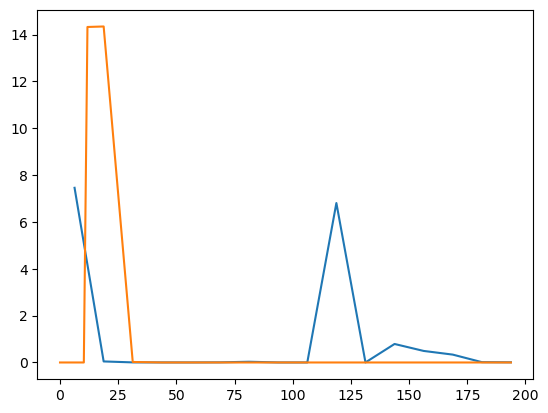

In [490]:
fig, ax = p.subplots()

# for i in range(64):
#     ax.plot(z_vals_fine[i,0,:,0]*200, weights_fine[i,0,:])

# print(weights_coarse)

print(np.shape(weights_fine))
print(np.shape(width_fine))
print(np.shape(tf.math.reduce_sum(weights_fine* width_fine, axis = 2) ))


i = 0
# ax.plot(z_vals_coarse[i,0,:,0]*200, weights_coarse[i,0,:])
ax.plot(z_vals_coarse[i,0,:,0]*200, weights_coarse_scaled[i,0,:])
s = tf.math.reduce_sum(weights_fine* width_fine, axis = 2)[i,0,None]
ax.plot(z_vals_fine[i,0,:,0]*200, weights_fine[i,0,:]/s) 

# ax.set_xlim([0,25])

In [491]:
rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
print("before", z_vals_coarse[look_at,0,:,0])

#move z vals coarse to center of histogram bins ~~~~~~~~~~~
# w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
# padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
# w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001) #TODO-- issue here??
# z_vals_coarse = z_vals_coarse + w_coarse/2
# print("w_coarse", w_coarse[look_at,0,:,0])
w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
w_coarse = tf.concat([w_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
print("w_coarse", w_coarse[look_at,0,:,0])
z_vals_coarse = z_vals_coarse + w_coarse/2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   

print("after", z_vals_coarse[look_at,0,:,0])
# print("after", z_vals_coarse[look_at,0,:,0] + w_coarse[look_at, 0, :, 0]/2)

before tf.Tensor(
[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375], shape=(16,), dtype=float32)
w_coarse tf.Tensor(
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625], shape=(16,), dtype=float32)
after tf.Tensor(
[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125
 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875], shape=(16,), dtype=float32)


tf.Tensor(
[7.463169   0.04331575 0.00274331 0.00136782 0.00098354 0.00493594
 0.0301181  0.00086138 0.00100521 6.813171   0.00108101 0.7897193
 0.49226418 0.33546433 0.01333201 0.00646743], shape=(16,), dtype=float32)


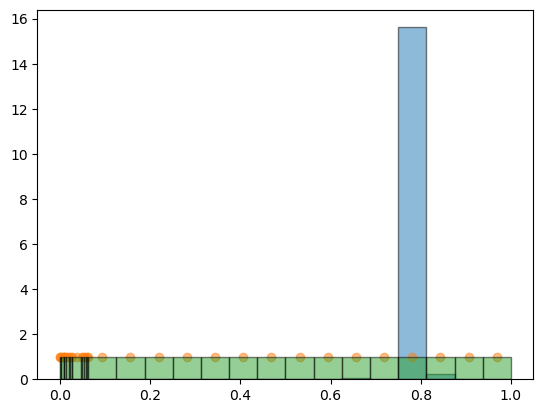

In [502]:
from coarse_network_utils import resample_z_vals

print(weights_coarse[0,0,:,0])

look_at = 2
z_vals_fine, width_fine = resample_z_vals(z_vals_coarse - width_coarse/2, 
                                          weights_coarse,
#                                           weights_coarse + np.ones_like(weights_coarse),
                                          width_coarse,
                                          n_resample=n_bins_fine)
z_vals_fine = z_vals_fine[:,:,:,None]
# print(width_fine[look_at,0,:])
# print(tf.math.reduce_sum(width_fine[look_at,0,:])) #make sure this adds up to exactly 1
# print(z_vals_coarse[look_at,0,:,0])
# print(z_vals_fine[look_at,0,:,0])
# print(width_fine[look_at,0,:]/2)

fig, ax = p.subplots()
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = width_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(z_vals_fine[look_at,0,:,0], tf.ones_like(z_vals_fine[look_at,0,:,0]), alpha = 0.5)
ax.bar(z_vals_fine[look_at,0,:,0], tf.ones_like(z_vals_fine[look_at,0,:,0]), 
       width = width_fine[look_at,0,:], label = "predicted density", edgecolor = 'black', alpha = 0.5);

In [503]:
print(np.shape(width_coarse))
print(np.shape(width_fine))

(64, 8, 16, 1)
(64, 8, 32)


(64, 8, 16)
why does this not match 
 tf.Tensor(0.9211485, shape=(), dtype=float32)
this 
 tf.Tensor(0.9211485, shape=(), dtype=float32)
tf.Tensor(
[-0.          0.9199482   0.00120024 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ], shape=(16,), dtype=float32)


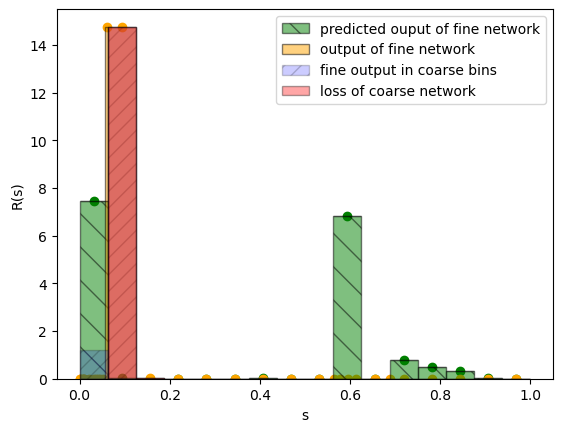

In [505]:
#look how actual network computes loss
depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)

#normalized area of each bar segment
area_fine = tf.math.reduce_sum(weights_fine * width_fine, axis = 2) #/ tf.math.reduce_sum(weights_fine * width_fine, axis = 2)[:,:,None]
weights_fine = weights_fine / area_fine[:,:,None]

loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                        z_vals_fine[:,:,:,0], 
                                                        weights_coarse[:,:,:,0], 
                                                        weights_fine, 
                                                        width_coarse[:,:,:,0],
                                                        width_fine[:,:,:],
                                                        debug = True)

mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
test = tf.math.reduce_sum(L_along_ray, axis = 2)
print("why does this not match \n", test[look_at,0])

look_at = 0
# print(z_vals_coarse[look_at,0,:,0])
# print(z_vals_fine[look_at,0,:,0])
print("this \n", loss_coarse[look_at,0])
print(L_along_ray[look_at,0,:])
# test = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)
# print(test[look_at,0])
# print(tf.math.reduce_sum(weights_fine[look_at,0,:] * width_fine[look_at,0,:])/ test[look_at, 0])
# print(weights_fine[look_at,0,:])

fig, ax = p.subplots()
ax.scatter(z_vals_coarse[look_at,0,:,0],  weights_coarse[look_at,0,:,0], color  = 'green')
ax.scatter(z_vals_fine[look_at,0,:],  weights_fine[look_at,0,:], color = 'orange')
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = width_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
#???
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width = width_fine[look_at,0,:], 
   label = "output of fine network", alpha = 0.5, color = 'orange', edgecolor = 'black');

ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width = width_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);
#stacked bar chart for loss
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at, 0,:] /width_coarse[look_at,0,:,0],
       width = width_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0],
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper right")
# ax.set_ylim([0,10])
#THESE NEED TO ADD UP TO EXACTLY 1!
# print(tf.math.reduce_sum(width_coarse[look_at,0,:]))
# print(tf.math.reduce_sum(width_fine[look_at,0,:]))
# print(tf.math.reduce_sum(width_fine[look_at,0,:] * weights_fine[look_at,0,:]))
w_coarse = w_coarse[:,:,:,None] #bring back to same size as in training loop for consistancy
w_fine = w_fine[:,:,:,None]

In [485]:
print(z_vals_coarse[0,0,:,0]+width_coarse[0,0,:,0]/2)
print(tf.math.reduce_sum(weights_fine[look_at,0,:9] * width_fine[look_at,0,:9])/1.25)
print(width_fine[0,0,:10])

tf.Tensor(
[0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625
 0.6875 0.75   0.8125 0.875  0.9375 1.    ], shape=(16,), dtype=float32)
tf.Tensor(0.7990745, shape=(), dtype=float32)
tf.Tensor(
[0.         0.00487253 0.00357187 0.01036532 0.01829717 0.00337194
 0.00425863 0.01776254 0.0625     0.0625    ], shape=(10,), dtype=float32)


In [49]:
#simple fix for very sparse fine bins-- require resample bins function to repeat the 
# random sample locations in addition to the importance sampling

a = 2*tf.random.uniform([3,4])
b = tf.ones_like(a)

a = tf.concat([a,b], axis = 0 )
a = tf.sort(a, axis = 0)
print(a)
print(a.shape[1])

tf.Tensor(
[[0.42222023 0.48580527 0.5718026  0.2771318 ]
 [0.6280563  0.5027199  0.5927005  1.        ]
 [1.         1.         0.6341946  1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.0426316 ]
 [1.3184469  1.0235827  1.         1.7409616 ]], shape=(6, 4), dtype=float32)
4


In [ ]:
#idea-- do something about "realized density" in our importance sampling strategy here??
#  points > 0.5 for this scene are almost always going to be occluded. Deep inside buildings, etc. 

# Our fine network will output a density of 1 there, (which will lead the coarse network to resample there)
# but the rendering 

# TODO:  
1. expand z_vals to correct dimensions
2. get widths_fine with TF
3. Make dummy coarse data
4. get loss function working in parallel with TF
5. do inverse sampling from coarse network
6. get inverse sampling working efficiently in parallel

* create coarse network
* figure out stop gradient order
* create train loop
* tune

In [ ]:
# print(model_fine.summary())
# print(model_coarse.summary())

In [ ]:
#fix segment_sum dimension reduction bug
##AAAAAaaaaAAAAaaaHHHhhHHhhhhh!
# def safe_segment_sum(data, segment_ids, num_segments):
#     # Initialize an array to store the segment sums
#     segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
#     # Compute the segment sums using tensor_scatter_nd_add
#     segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
#     return segment_sums
# def safe_segment_sum(data, segment_ids, num_segments):
#     segment_ids = tf.expand_dims(segment_ids, axis=-1)
#     segment_sums = tf.tensor_scatter_nd_add(tf.zeros((num_segments,), dtype=data.dtype), segment_ids, data)
#     return segment_sums


def safe_segment_sum(data, segment_ids, num_segments):
    # Extract dimensions
    batch_size, num_rays, num_samples = tf.shape(data)
    
    # Flatten data and segment_ids
    data_flat = tf.reshape(data, [-1])
    segment_ids_flat = tf.reshape(segment_ids, [-1])
    
    # Calculate indices
    indices = tf.stack([
        tf.range(batch_size * num_rays * num_samples),  # Flat indices
        segment_ids_flat
    ], axis=1)
    
    # Initialize segment_sums tensor
    segment_sums = tf.zeros([batch_size * num_rays, num_segments], dtype=data.dtype)
    
    # Scatter the data
    segment_sums = tf.tensor_scatter_nd_add(segment_sums, indices, data_flat)
    
    # Reshape segment_sums to match original shape
    segment_sums = tf.reshape(segment_sums, [batch_size, num_rays, num_segments])
    
    return segment_sums

zf = tf.linspace(0.1,.79,32)
zc = tf.linspace(0.,1., 8)
# print("zf: \n", zf.numpy())
zf = tf.tile(zf[None,None,:], [5,2,1])
zc = tf.tile(zc[None,None,:], [5,2,1])
# print("zf: \n", zf.numpy())

print("zf: \n", np.shape(zf))
print("zc: \n", np.shape(zc))#, zc.numpy())

idx = tf.searchsorted(zc, zf, side='right') - 1
print("\n idx: \n", np.shape(idx)) #,idx)

test = safe_segment_sum(tf.ones_like(zf), idx, zc.shape[2])
print("\n test: \n", np.shape(test))
# print(test)

In [ ]:
def foo(inputs):
    x, y = inputs
    out = tf.math.reduce_sum(x) + y
    return out

# Define a function that processes each element using foo
def map_fn(index):
    return foo((d[index[0], index[1]], y[index[0], index[1]]))

a = tf.constant([[1, 2, 3, 1], [1, 2, 3, 0]])
b = tf.constant([[4, 5, 6, 1], [1, 2, 8, 1]])
c = tf.constant([[7, 8, 9, 1], [1, 2, 3, 1]])
d = tf.stack([a, b, c])
y = tf.constant([[1, 1], [1, 1], [1, 1]])  # Shape (3, 2)

# Create indices to map over
indices = tf.stack(tf.meshgrid(tf.range(d.shape[0]), tf.range(d.shape[1]), indexing='ij'), axis=-1)
indices = tf.reshape(indices, (-1, 2))

# Use tf.map_fn to apply the function over indices
results = tf.map_fn(map_fn, indices, fn_output_signature=tf.int32)
results = tf.reshape(results, (d.shape[0], d.shape[1]))

# Test outputs
print(results)
print(results[2, 1])
print(foo((d[2, 1], y[2, 1])))